# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import dask.dataframe as dd
import pandas as pd
import numpy as np

c:\Users\hyunh\AppData\Local\miniconda\envs\dsi_participant\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
C:\Users\hyunh\AppData\Local\Temp\ipykernel_2632\432375476.py:7: DeprecationWarning: The current Dask DataFrame implementation is deprecated. 
In a future release, Dask DataFrame will use new implementation that
contains several improvements including a logical query planning.
The user-facing DataFrame API will remain unchanged.

The new implementation is already available and can be enabled by
installing the dask-expr library:

    $ pip install dask-expr

and turning the query planning option on:

    >>> import dask
    >>> dask.config.set({'dataframe.query-planning': True})
    >>> import dask.dataframe as dd

API documentation for the new implementation is available at
https://docs.dask.org/en/stable/dask-expr-api.html

Any fee

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [84]:
# The model objective is to predict the area affected by forest fires given the features set. 
X = fires_dt.drop(columns = ['area'])
#y = pd.DataFrame(np.log1p(fires_dt[['area']]), columns=['area'])
y = fires_dt[['area']]

print(X.head())
print(y.head())

   coord_x  coord_y month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain
0        7        5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0
1        7        4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0
2        7        4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0
3        8        6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2
4        8        6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0
   area
0   0.0
1   0.0
2   0.0
3   0.0
4   0.0


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


In [89]:
preproc1 = ColumnTransformer(
    transformers=[
        ('numeric_transfomer', StandardScaler(), numerical_features), 
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features) 
    ], remainder='passthrough'
)


In [90]:
print(preproc1)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric_transfomer', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [91]:
from sklearn.preprocessing import RobustScaler, PowerTransformer

preproc2 = ColumnTransformer(
  transformers = [
    ('numeric_scaler', RobustScaler(), numerical_features),
    ('numeric_transfomer', PowerTransformer(), numerical_features),
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features)
  ], remainder='passthrough'
)

print(preproc2) 

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric_scaler', RobustScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('numeric_transfomer', PowerTransformer(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
# Pipeline A = preproc1 + baseline
pipe_A = Pipeline(
    [
        ('preproc1', preproc1), 
        ('model', RandomForestRegressor(random_state=0))
    ]
)
pipe_A

Pipeline(steps=[('preproc1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transfomer',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('model', RandomForestRegressor(random_state=0))])

In [93]:
# Pipeline B = preproc2 + baseline
pipe_B = Pipeline(
    [
        ('preproc2', preproc2), 
        ('model', RandomForestRegressor(random_state=0))
    ]
)
pipe_B

Pipeline(steps=[('preproc2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_scaler',
                                                  RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('numeric_transfomer',
                                                  PowerTransformer(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('model', RandomForestRegressor(random_state=0))])

In [68]:
# Pipeline C = preproc1 + advanced model
from sklearn.ensemble import GradientBoostingRegressor
pipe_C = Pipeline(
    [
        ('preproc1', preproc1), 
        ('model', GradientBoostingRegressor(random_state=0))
    ]
)
pipe_C

Pipeline(steps=[('preproc1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transfomer',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('model', GradientBoostingRegressor(random_state=0))])

In [94]:
# Pipeline D = preproc2 + advanced model
pipe_D = Pipeline(
    [
        ('preproc2', preproc2), 
        ('model', GradientBoostingRegressor(random_state=0))
    ]
)
pipe_D
    

Pipeline(steps=[('preproc2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_scaler',
                                                  RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('numeric_transfomer',
                                                  PowerTransformer(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('model', GradientBoostingRegressor(random_state=0))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [95]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train,  y_validate = train_test_split(X_rest, y_rest, test_size=0.2, random_state=42)


In [96]:
# Store best results for each pipeline and perform Grid Search
best_params_results = {}

# Loop through each pipeline and perform Grid Search
for pipe_name, pipe in zip(["pipe_A", "pipe_B", "pipe_C", "pipe_D"], [pipe_A, pipe_B, pipe_C, pipe_D]):
    
    # Select parameter grid based on model type
    if pipe.get_params()['model'].__class__.__name__ == 'GradientBoostingRegressor':
        param_grid = {
            'model__n_estimators': [50, 100, 300],  
            'model__learning_rate': [0.001, 0.01, 0.1],  
            'model__max_depth': [3, 5],  
            'model__subsample': [1.0]  
        }
        filter_columns = [
            'param_model__n_estimators', 'param_model__learning_rate',
            'param_model__max_depth', 'param_model__subsample'
        ]
    
    else:  # RandomForestRegressor
        param_grid = {
            'model__n_estimators': [50, 100],  
            'model__max_depth': [None, 5, 10, 15],
            'model__min_samples_split': [2, 5, 10, 20]
        }
        filter_columns = [
            'param_model__n_estimators', 'param_model__max_depth', 'param_model__min_samples_split'
        ]

    # Define the scoring metric
    scoring = 'r2'  # R² score (higher is better)

    # Perform Grid Search with optimizations
    grid_cv = GridSearchCV( 
        estimator=pipe, 
        param_grid=param_grid, 
        scoring=scoring,  
        cv=3,  # Reduced CV
        refit=scoring,
        n_jobs=-1  # Parallel computing
    )

    print(f"\nRunning Grid Search for {pipe_name}...")

    # Fit the model
    grid_cv.fit(X_train, y_train)

    # Store best parameters and score
    best_params_results[pipe_name] = {
        "Best Params": grid_cv.best_params_,
        "Best Score": grid_cv.best_score_
    }

    # Convert cv_results_ into a DataFrame
    res = pd.DataFrame(grid_cv.cv_results_)

    # Select relevant columns for analysis
    filter_columns.extend(['mean_test_score', 'std_test_score', 'rank_test_score'])
    
    res_filtered = res[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'] + filter_columns].sort_values('rank_test_score')

    # Display results
    print(f"\nBest results for {pipe_name}:")
    print(res_filtered.head())  # Display top results

# Print overall best parameters and scores
print("\nSummary of Best Hyperparameters and Scores for All Pipelines:")
for pipe_name, result in best_params_results.items():
    print(f"\n{pipe_name}:")
    print(f"  Best Params: {result['Best Params']}")
    print(f"  Best Score: {result['Best Score']:.4f}")



Running Grid Search for pipe_A...


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Best results for pipe_A:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15       0.308639      0.002634         0.015524        0.000971   
31       0.236508      0.020805         0.012793        0.001973   
7        0.347970      0.018538         0.021414        0.004339   
23       0.306489      0.014976         0.016825        0.000967   
14       0.168936      0.020552         0.014590        0.005118   

    param_model__n_estimators param_model__max_depth  \
15                        100                      5   
31                        100                     15   
7                         100                   None   
23                        100                     10   
14                         50                      5   

    param_model__min_samples_split  mean_test_score  std_test_score  \
15                              20        -0.780707        0.998906   
31                              20        -0.802125        1.019519   
7              

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Best results for pipe_B:
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15       0.381006      0.012326         0.023842        0.003328   
14       0.198618      0.005900         0.020920        0.002054   
31       0.367966      0.025639         0.013304        0.003493   
7        0.496572      0.013437         0.023434        0.006247   
23       0.625781      0.034228         0.049416        0.012762   

    param_model__n_estimators param_model__max_depth  \
15                        100                      5   
14                         50                      5   
31                        100                     15   
7                         100                   None   
23                        100                     10   

    param_model__min_samples_split  mean_test_score  std_test_score  \
15                              20        -0.806276        1.035219   
14                              20        -0.820326        1.074684   
31             

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Best results for pipe_C:
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       0.124912      0.004649         0.010317        0.001482   
0       0.092815      0.001412         0.011565        0.002691   
4       0.210144      0.006452         0.009845        0.000166   
1       0.166776      0.004266         0.011675        0.002777   
2       0.468588      0.004881         0.010236        0.000825   

   param_model__n_estimators  param_model__learning_rate  \
3                         50                       0.001   
0                         50                       0.001   
4                        100                       0.001   
1                        100                       0.001   
2                        300                       0.001   

   param_model__max_depth  param_model__subsample  mean_test_score  \
3                       5                     1.0        -0.097153   
0                       3                     1.0        -0.099681   


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


# Evaluate

+ Which model has the best performance?

The model Gradient Boosting (pipe_C) perform better among the four due to an R_squared closest to 1. That being said, all four models result negative R-squared, which indicates thatthe models are slightly worse than predicting the mean.

# Export

+ Save the best performing model to a pickle file.

In [97]:
best_model = grid_cv.best_estimator_ 
best_model

import pickle

model_filename = "best_model.pkl"

with open(model_filename, "wb") as file:
    pickle.dump(best_model, file)

print(f"Best model saved as {model_filename}")



Best model saved as best_model.pkl


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [98]:
import shap
from sklearn.inspection import permutation_importance

with open(model_filename, "rb") as file:
    pipe_loaded = pickle.load(file)


pi_res = permutation_importance(
    pipe_loaded, X_test, y_test, 
    n_repeats=30, 
    scoring = "r2")

importances_dt = pd.DataFrame(pi_res.importances).T
importances_dt.columns = X_test.columns

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


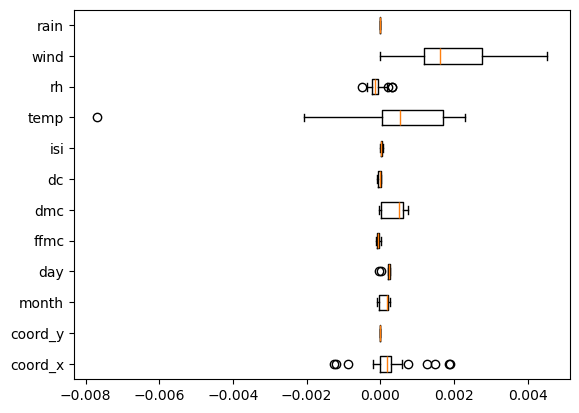

In [99]:
import matplotlib.pyplot as plt
bp = plt.boxplot(importances_dt, vert = False,  labels = importances_dt.columns)

In [100]:
pd.concat(
    [
        pd.Series(pi_res.importances_mean, index = X_test.columns, name = 'Mean Importance'),
        pd.Series(pi_res.importances_std, index = X_test.columns, name = "Std Importance")
    ], 
    axis = 1).sort_values("Mean Importance", ascending  = False)

,Mean Importance,Std Importance
wind,1.854897e-03,0.001402
temp,4.344345e-04,0.001898
dmc,3.454117e-04,0.000297
coord_x,2.219457e-04,0.000701
day,2.218651e-04,0.000065
month,1.128166e-04,0.000124
isi,2.325342e-05,0.000024
rain,0.000000e+00,0.000000
coord_y,-8.950716e-07,0.000002
dc,-2.112106e-05,0.000041


In [102]:
print("Pipeline steps:", pipe_loaded.named_steps.keys())


Pipeline steps: dict_keys(['preproc2', 'model'])


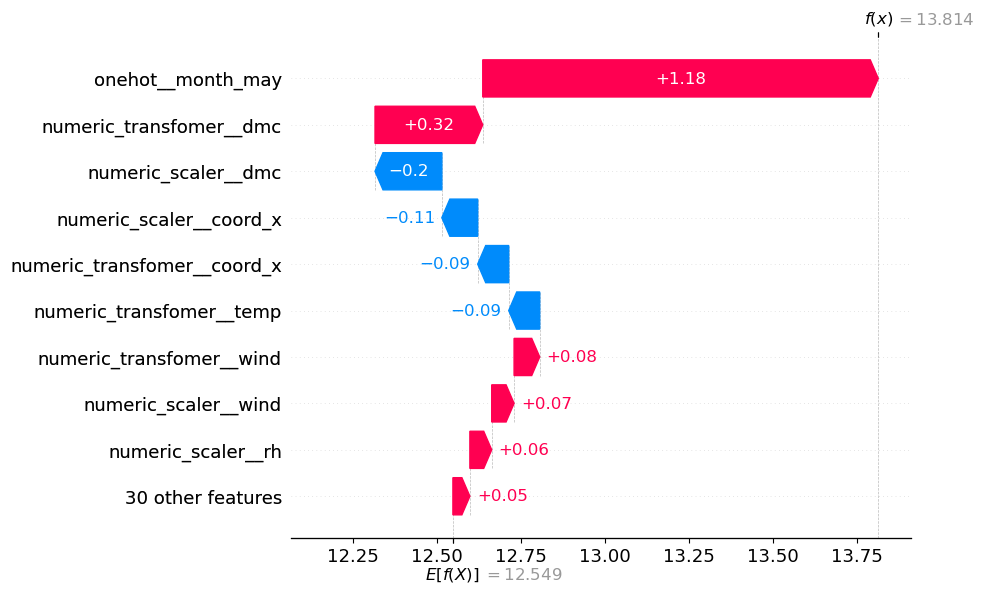

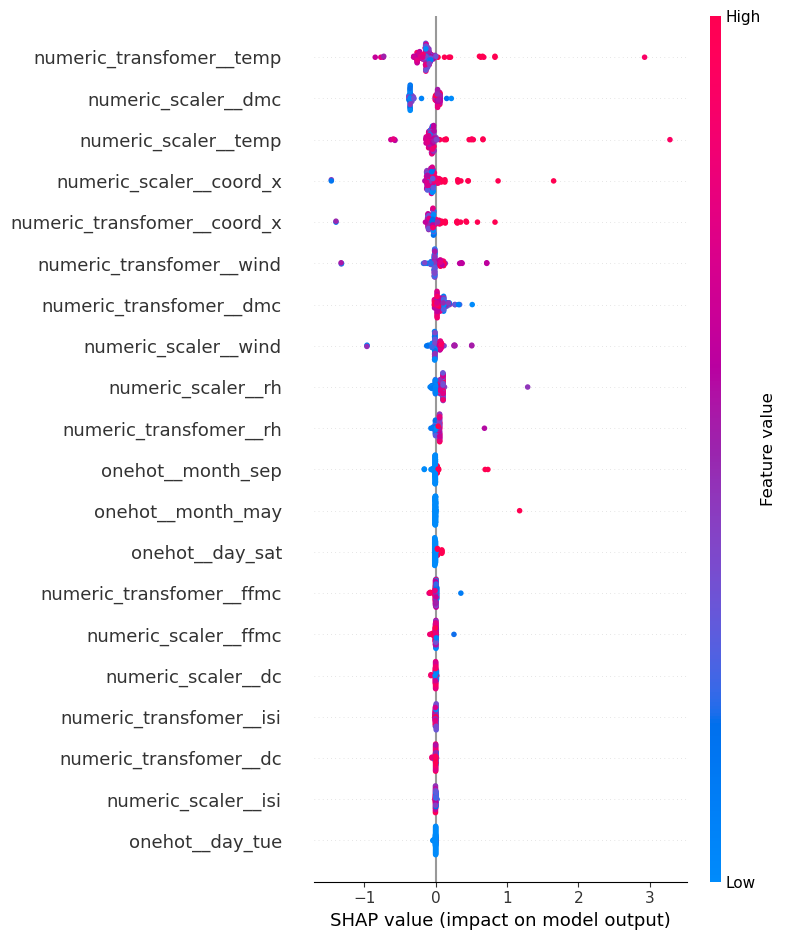

In [ ]:

preprocessor = pipe_loaded.named_steps['preproc2']
model = pipe_loaded.named_steps['model']  # Gradient Boosting Regressor

# Transform the test data using the preprocessing pipeline
X_test_transformed = preprocessor.transform(X_test)

# Use SHAP TreeExplainer for tree-based models like Gradient Boosting
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# Select a specific observation to explain
sample_index = 0
shap_values_sample = shap_values[sample_index]

# Get expected value (mean model prediction)
expected_value = explainer.expected_value

# Convert to SHAP Explanation format
shap_exp = shap.Explanation(values=shap_values_sample, 
                            base_values=expected_value, 
                            feature_names=preprocessor.get_feature_names_out())

# Visualize SHAP feature importance 
shap.waterfall_plot(shap_exp)

# Summary plot for global feature importance
shap.summary_plot(shap_values, X_test_transformed, feature_names=preprocessor.get_feature_names_out())


In general, across the complete training set, features such as [wind, temp, dmc, coord_x, day, month] are the most important. Features of rain (suprisingly), coord_y, dc, ffmc, and rh are least important.

*(Answer here.)*

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.